# あらすじジェネレータ
本のタイトルからあらすじ(キャプション)を生成

## データの用意

In [1]:
import pickle
import numpy as np
from utilities.word2id import Word2ID

with open('data/KADOKAWA-caption-id-dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

t_wd2id = Word2ID()
c_wd2id = Word2ID()
t_wd2id.deserialize(dataset['title'])
c_wd2id.deserialize(dataset['caption'])

n_data = len(t_wd2id.data)
n_train = n_data

x_vocab = len(t_wd2id.wd2id)
y_vocab = len(c_wd2id.wd2id)

X_train = [np.array(x, dtype=np.int32) for x in t_wd2id.data]
Y_train = [np.array(x, dtype=np.int32) for x in c_wd2id.data]
X_train = np.array(X_train)
Y_train = np.array(Y_train)

## モデルの作成とトレーニング

### モデル概要
入力 X $\rightarrow$ Encoder $\rightarrow$ 変換素子 $\rightarrow$ Decoder $\rightarrow$ 出力　<br>
ミニバッチ学習ができる様に実装

### Chainer Tips
chainer.links.LSTMでは，シーケンスを長い順に並べなおしてtranspose_sequenceを行うことで可変長系列をパディングを用いずに扱える.<br>
<ul><li> 並べ替え <br> X[np.argsort([-len(x) for x in X])] </li>
<li> 使い方 <br>
sequences = [<br>
&nbsp;&nbsp;np.array([w1, w2, w3, w4]),  # "w1w2w3w4" という系列、以下同じ<br>
&nbsp;&nbsp;np.array([w5, w6, w7]),<br>
&nbsp;&nbsp;np.array([w8, w9])<br>
]<br>
words = transpose_sequnce(sequences)  # wordsは[[w1, w5, w8], [w2, w6, w9], [w3, w7], [w4]]になる<br>
for w in words:<br>
&nbsp;&nbsp;lstm(w)<br>
h = lstm.h    # h.data.shape == (3,)<br>
</li></ul>

In [3]:
from chainer import Chain, links as L, functions as F
from chainer import Variable

class Seq2Seq(Chain):
    def __init__(self, n_in, n_mid, n_out, ignore_label=-1):
        super(Seq2Seq, self).__init__(
            embedx = L.EmbedID(n_in, n_mid, ignore_label=ignore_label),
            embedy = L.EmbedID(n_out, n_mid, ignore_label=ignore_label),
            lstm_i = L.LSTM(n_mid, n_mid),  # Encoder用LSTM
            lstm_c = L.LSTM(n_mid, n_mid),  # Encoder -> Decoder 変換素子
            lstm_o = L.LSTM(n_mid, n_mid),  # Decoder用LSTM
            out    = L.Linear(n_mid, n_out)
        )
        self.ignore_label = ignore_label
    
    def __call__(self, X, Y):
        self.reset_state()
        p = F.dropout(self.encode(X))
        p = F.dropout(self.lstm_c(p))
        loss = self.decode_train(p, Y)
        return loss

    def predict(self, X, max_iter=30):
        self.reset_state()
        p = self.encode(X)
        return self.decode(self.lstm_c(p), n_iter=max_iter)

    def encode(self, X):
        sortedidx = np.argsort([-len(x) for x in X]).astype(np.int32)
        X_T = F.transpose_sequence(X[sortedidx])

        for x in X_T:
            self.lstm_i(self.embedx(x))
        
        h = F.array.permutate.permutate(self.lstm_i.h, np.argsort(sortedidx).astype(np.int32))
        return h
          
    def decode_train(self, p, Y):
        sortedidx = np.argsort([-len(y) for y in Y]).astype(np.int32)
        Y_T = F.transpose_sequence(Y[sortedidx])
        p = F.array.permutate.permutate(p, sortedidx)
        
        loss = 0
        y_prev = p  # 最初の入力は(変換素子を通した)Encoderからの出力
        for y in Y_T:
            h = F.dropout(self.lstm_o(y_prev))
            q = self.out(h)
            loss += F.softmax_cross_entropy(q[:len(y)], y)
            y_prev = self.embedy(y)
        
        return loss
    
    def decode(self, p, n_iter=30, eos=1):
        P = []
        y_prev = p
        for _ in range(n_iter):
            q = self.out(self.lstm_o(y_prev))
            P.append(np.argmax(q.data, axis=1).astype(np.int32))
            y_prev = self.embedy(P[-1])
        P = np.array(P).T
        
        # 出力用に<eos>以下を切り捨てる
        out = []
        for p in P:
            for j, val in enumerate(p):
                if val == eos:
                    break
            out.append(p[:j+1])
        return np.array(out)
    
    def reset_state(self):
        self.lstm_i.reset_state()
        self.lstm_c.reset_state()
        self.lstm_o.reset_state()


In [51]:
from chainer import optimizers, Variable
from ipywidgets import FloatProgress
from IPython.display import display

n_mid =300
n_epoch = 150
n_batch = 100

model = Seq2Seq(x_vocab, n_mid, y_vocab)
optimizer = optimizers.Adam()
optimizer.setup(model)

fp = FloatProgress(min=0, max=n_train*n_epoch)
display(fp)

error = []
for epoch in range(n_epoch):
    shuffidx = np.random.permutation(n_train)
    for i in range(0, n_train, n_batch):
        X_batch = X_train[shuffidx[i : i + n_batch if i + n_batch < n_train else n_train]]
        Y_batch = Y_train[shuffidx[i : i + n_batch if i + n_batch < n_train else n_train]]
        
        model.zerograds()
        loss = model(X_batch, Y_batch)
        loss.backward()
        optimizer.update()
        error.append(loss.data / n_batch)
        fp.value = n_train*epoch + i + 1

## トレーニング結果の表示

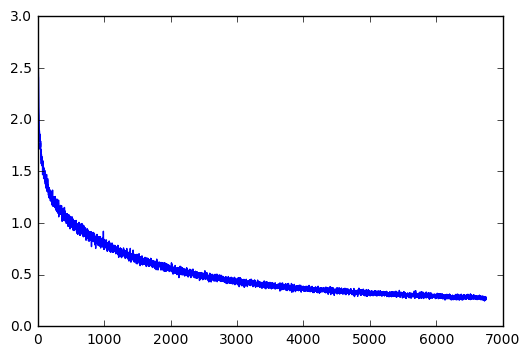

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(error)

### モデルの保存
トレーニングしたモデルデータをトレーニング時のデータと共に保存．<br>
・mdlデータ
data = {'model' : モデルデータ,
        'epochs': エポック数,
        'errors': 誤差履歴,
        'note'  : note}

In [54]:
note = 'n_train: %d, n_mid: %d\n'%(n_train, n_mid) + \
       '入力 X → Encoder → dropout → 変換素子 → dropout → Decoder → 出力'
data = {'model' : model,
        'epochs': n_epoch,
        'errors': error,
        'note'  : note}
with open('model/seq2seq-full-%depochs.mdl'%n_epoch, 'wb') as f:
    pickle.dump(data, f)

## 予測確認

In [5]:
import pickle
with open('model/seq2seq-full-moredropout-150epochs.mdl', 'rb') as f:
    modeldata = pickle.load(f)

md = modeldata['model']

title =['この素晴らしい世界に祝福を！２',
        'あいまいみー ～Surgical Friends～',
        '小林さんちのメイドラゴン',
        'Fate／Grand Order ‐First Order‐',
        '幼女戦記',
        '亜人ちゃんは語りたい',
        'ガウリールドロップアウト',
        'けものフレンズ',
        '学戦都市アスタリスク'
       ]
D = t_wd2id(title)
for i in range(len(D)):
    D[i].append(-1)
D = np.array([np.array(d, dtype=np.int32) for d in D])

P = c_wd2id.translate(md.predict(D, max_iter=50))
for i, p in enumerate(P):
    print('『'+title[i]+'』:\n    ', p)

『この素晴らしい世界に祝福を！２』:
     フ ル メ タ ル ・ パ ニ ッ ク ！ 」 <eos> 
『あいまいみー ～Surgical Friends～』:
     ス ニ ー カ ー 大 賞 《 優 秀 賞 》 受 賞 作 デ ビ ュ ー ！ <eos> 
『小林さんちのメイドラゴン』:
     生 活 字 中 毒 舌 メ イ ド タ イ ル ・ ミ ミ ナ ニ カ の か ？ 文 化 祭 編 ！ <eos> 
『Fate／Grand Order ‐First Order‐』:
     戦 慄 の 学 園 サ バ イ バ ル サ ス ペ ン ス 第 四 弾 ！ <eos> 
『幼女戦記』:
     大 人 気 ア ニ メ 『 ハ イ ス ク ー ル ・ フ リ ー ト 』 の 公 式 ス ピ ン オ フ ノ ベ ル 、 第 二 弾 ！ <eos> 
『亜人ちゃんは語りたい』:
     ア ニ メ 化 企 画 進 行 中 ！ <eos> 
『ガウリールドロップアウト』:
     コ ミ ッ ク ス 第 一 巻 も 同 時 発 売 ！ <eos> 
『けものフレンズ』:
     魔 法 と 奇 跡 と 罪 の 幻 想 夜 話 。 <eos> 
『学戦都市アスタリスク』:
     ― ― 聖 地 に 陥 入 れ 替 わ り ラ ブ コ メ 、 最 強 の 敵 ！ ？ <eos> 


In [17]:
for t, c in zip(t_wd2id.translate(X_train[:10]), c_wd2id.translate(Y_train[:10])):
    print('『'+t+'』\n    '+c)

『ピ リ オ ド か ら は じ ま る 魔 導 機 書 <eos> 』
    愛 を 教 え て く だ さ い ♪ <eos> 
『く ず ク マ さ ん と ハ チ ミ ツ J K <eos> 』
    ク ズ す ら と ろ け る 最 高 級 < ド タ バ タ > ラ ブ コ メ <eos> 
『エ ル フ で ビ キ ニ で マ シ ン ガ ン ！ <eos> 』
    異 世 界 × ミ リ タ リ ー × ハ ー レ ム ! ? <eos> 
『モ ー テ ‐ 夢 の 狭 間 で 泣 く 天 使 ‐ <eos> 』
    ― ― 俺 は 、 ア ミ ヤ を こ の 手 で 殺 し た い <eos> 
『中 の 下 ！   ラ ン ク ４ ． 下 の 下 に 落 ち ぶ れ た オ レ <eos> 』
    修 学 旅 行 、 ク リ ス マ ス 、 裏 切 り 者 ― ― 男 ・ 成 道 、 決 断 の 刻 、 迫 る ！ <eos> 
『仮 面 の メ イ ド ガ イ   メ イ ド 革 命 Ｖ ｅ ｒ ． <eos> 』
    ド ラ ゴ ン エ イ ジ の 人 気 コ ミ ッ ク ス が 初 の 小 説 化 ! ! <eos> 
『Ｖ ａ ｒ ｏ ｆ ｅ ｓ ｓ Ｉ   － ヴ ァ ロ フ ェ ス － <eos> 』
    闇 の 鴉 。 究 極 の ダ ー ク ヒ ー ロ ー 誕 生 <eos> 
『ス レ イ ヤ ー ズ ３   サ イ ラ ー グ の 妖 魔 <eos> 』
    い つ の 間 に か 賞 金 首 に な っ て い た リ ナ 一 行 。 赤 法 師 の 遺 産 と は ! ? <eos> 
『銀 の 十 字 架 と ド ラ キ ュ リ ア Ｖ <eos> 』
    ル シ ュ ラ と ミ ラ ル カ ― ― 吸 血 鬼 の 『 真 祖 』 が 二 人 ! ? <eos> 
『フ ァ ン タ ジ ア 文 庫 ２ ５ 周 年 ア ニ バ ー サ リ ー ブ ッ ク <eos> 』
    フ ァ ン タ ジ ア 文 庫 ２ ５ 周 年 の ス タ ー ト を 飾 る お 祭 り 文 庫 が 登 場 ！ ！ <eos> 


In [15]:
D = X_train[:10]

P = c_wd2id.translate(md.predict(D, max_iter=50))
for t, p in zip(t_wd2id.translate(X_train[:10]), P):
    print('『'+t+'』:\n    ', p)

『ピ リ オ ド か ら は じ ま る 魔 導 機 書 <eos> 』:
     い よ い よ 激 化 す る 争 奪 戦 ！ <eos> 
『く ず ク マ さ ん と ハ チ ミ ツ J K <eos> 』:
     ク ラ イ マ ッ ク ス へ 向 け て 、 稀 人 た ち の 壮 大 な る 闘 い が は じ ま る ！ <eos> 
『エ ル フ で ビ キ ニ で マ シ ン ガ ン ！ <eos> 』:
     異 世 界 × 忘 却 × 異 能 の 武 器 の バ ト ル ア ク シ ョ ン 第 ２ 幕 ！ <eos> 
『モ ー テ ‐ 夢 の 狭 間 で 泣 く 天 使 ‐ <eos> 』:
     ― ― 俺 は 、 魔 法 使 い の 恋 に … … <eos> 
『中 の 下 ！   ラ ン ク ４ ． 下 の 下 に 落 ち ぶ れ た オ レ <eos> 』:
     第 1 9 回 電 撃 小 説 大 賞 最 終 選 考 作 ！ 都 市 の 闇 に 潜 ん だ 連 続 殺 人 鬼 を 追 え ! ! <eos> 
『仮 面 の メ イ ド ガ イ   メ イ ド 革 命 Ｖ ｅ ｒ ． <eos> 』:
     ア ニ メ 化 企 画 進 行 中 。 麗 華 さ ん の 書 き 下 ろ し も 収 録 し た 短 編 集 第 二 弾 ！ <eos> 
『Ｖ ａ ｒ ｏ ｆ ｅ ｓ ｓ Ｉ   － ヴ ァ ロ フ ェ ス － <eos> 』:
     魔 法 と 科 学 が 混 在 す る 学 園 バ ト ル フ ァ ン タ ジ ー ！ <eos> 
『ス レ イ ヤ ー ズ ３   サ イ ラ ー グ の 妖 魔 <eos> 』:
     い つ の 間 に か ら く れ て い た … … 。 <eos> 
『銀 の 十 字 架 と ド ラ キ ュ リ ア Ｖ <eos> 』:
     リ ア ル と ス ト ー リ ー 。 小 説 版 第 ２ 弾 ！ <eos> 
『フ ァ ン タ ジ ア 文 庫 ２ ５ 周 年 ア ニ バ ー サ リ ー ブ ッ ク <eos> 』:
     フ ァ ン タ ジ ア 大 賞 受 賞 作 ！ 新 米 隊 、 魔 王 さ ま 、 シ リ ー ズ 完 結 編 ！ <eo

## Attentionを導入したSeq2Seq

### Attentionのための入力側LSTMのデータ保持
入力時のデータを大域的に保持
$$
H = \left[ \begin{matrix} H^{(1)} \\ H^{(2)} \\ \vdots \\ H^{(m)} \end{matrix} \right]
  = \left[ \begin{matrix}
       \left[ \begin{matrix} (\bf{h}_1^{(1)})^T \\ \vdots \\ (\bf{h}_{n_1}^{(1)})^T \end{matrix} \right] \\
       \vdots \\
       \left[ \begin{matrix} (\bf{h}_1^{(m)})^T \\ \vdots \\ (\bf{h}_{n_m}^{(m)})^T \end{matrix} \right] \\
    \end{matrix} \right]  \in \mathbb{R}^{m \times n_i \times l}
$$
$m$：ミニバッチ数，$n_i$：i番目のバッチデータの長さ，$l$：中間層のベクトルの次元


In [24]:
import numpy as np
from chainer import Chain, links as L, functions as F
from chainer import Variable

class Seq2SeqAttention(Chain):
    def __init__(self, n_in, n_mid, n_out, ignore_label=-1):
        super(Seq2SeqAttention, self).__init__(
            embedx = L.EmbedID(n_in, n_mid, ignore_label=ignore_label),
            embedy = L.EmbedID(n_out, n_mid, ignore_label=ignore_label),
            lstm_i = L.LSTM(n_mid, n_mid),  # Encoder用LSTM
            lstm_c = L.LSTM(n_mid, n_mid),  # Encoder -> Decoder 変換素子
            lstm_o = L.LSTM(n_mid, n_mid),  # Decoder用LSTM
            w_c    = L.Linear(n_mid, n_mid),
            #w_h    = L.Linear(n_mid, n_mid),
            w_ifo  = L.Linear(n_mid, 3*n_mid), # AttentionのInput Gate,Forget Gate,Output Gate
            out    = L.Linear(n_mid, n_out)
        )
        self.ignore_label = ignore_label
        self.n_mid = n_mid
    
    def __call__(self, X, Y):
        self.reset_state()
        p, H = self.encode(X)
        #p = F.dropout(p)
        p = F.dropout(self.lstm_c(p))
        loss = self.decode_train(p, H, Y)
        return loss

    def predict(self, X, max_iter=30, eos=1):
        self.reset_state()
        p, H = self.encode(X)
        return self.decode(self.lstm_c(p), H, n_iter=max_iter, eos=eos)

    def encode(self, X):
        sortedidx = np.argsort([-len(x) for x in X]).astype(np.int32)
        X_T = F.transpose_sequence(X[sortedidx])
        
        h = self.lstm_i(self.embedx(X_T[0]))
        H = [[np.copy(h_i.data)] for h_i in h]
        for x in X_T[1:]:
            h = self.lstm_i(self.embedx(x))[:x.shape[0]]
            for i, h_i in enumerate(h):
                H[i].append(np.copy(h_i.data))
        H = [np.array(H_i, dtype=np.float32) for H_i in H]
        
        H = [H[i] for i in np.argsort(sortedidx)]
        h = F.array.permutate.permutate(self.lstm_i.h, np.argsort(sortedidx).astype(np.int32))
        return h, H
    
    def decoder(self, y_prev, H, n_batch=None, train=True):
        if not n_batch:
            n_batch = len(H)
        h = self.lstm_o(y_prev)[:n_batch]
            
        c = []
        for H_i, o_i in zip(H, h):
            a_i = np.exp(np.dot(H_i, o_i.data))
            a_i = a_i / np.sum(a_i)
            c.append(np.dot(H_i.T, a_i))
        c = Variable(np.array(c).astype(np.float32))
        
        ifo = F.sigmoid(self.w_ifo(h))
        i = F.dropout(ifo[:,:self.n_mid], train=train)
        f = ifo[:,self.n_mid:2*self.n_mid]
        o = ifo[:,2*self.n_mid:]
        q = F.tanh(i*h + f*self.w_c(c)) * o
        return self.out(q)
    
    def decode_train(self, p, H, Y):
        sortedidx = np.argsort([-len(y) for y in Y]).astype(np.int32)
        Y_T = F.transpose_sequence(Y[sortedidx])
        p = F.array.permutate.permutate(p, sortedidx)
        H = [H[i] for i in sortedidx]
        
        loss = 0
        y_prev = p  # 最初の入力は(変換素子を通した)Encoderからの出力
        for y in Y_T:
            q = self.decoder(y_prev, H, len(y))
            loss += F.softmax_cross_entropy(q[:len(y)], y)
            y_prev = self.embedy(y)
        
        return loss
    
    def decode(self, p, H, n_iter=30, eos=1):
        P = []
        y_prev = p
        for _ in range(n_iter):
            q = self.decoder(y_prev, H, train=False)
            P.append(np.argmax(q.data, axis=1).astype(np.int32))
            y_prev = self.embedy(P[-1])
        P = np.array(P).T
        
        # 出力用に<eos>以下を切り捨てる
        out = []
        for p in P:
            for j, val in enumerate(p):
                if val == eos:
                    break
            out.append(p[:j+1])
        return np.array(out)
    
    def reset_state(self):
        self.lstm_i.reset_state()
        self.lstm_c.reset_state()
        self.lstm_o.reset_state()


In [25]:
from chainer import optimizers, Variable
from ipywidgets import FloatProgress
from IPython.display import display

n_mid =300
n_epoch = 300
n_batch = 100

model = Seq2SeqAttention(x_vocab, n_mid, y_vocab)
optimizer = optimizers.Adam()
optimizer.setup(model)

fp = FloatProgress(min=0, max=n_train*n_epoch)
display(fp)

error = []
for epoch in range(n_epoch):
    shuffidx = np.random.permutation(n_train)
    for i in range(0, n_train, n_batch):
        X_batch = X_train[shuffidx[i : i + n_batch if i + n_batch < n_train else n_train]]
        Y_batch = Y_train[shuffidx[i : i + n_batch if i + n_batch < n_train else n_train]]
        
        model.zerograds()
        loss = model(X_batch, Y_batch)
        loss.backward()
        optimizer.update()
        error.append(loss.data / n_batch)
        fp.value = n_train*epoch + i + 1
    
    if (epoch + 1) % 50 == 0:
        note = 'n_train: %d, n_mid: %d\n'%(n_train, n_mid) + \
               '入力 X → Encoder → 変換素子 → dropout → Decoder(Attention) → 出力' + \
               'Attention内部にLSTMのようなInputGate, ForgetGate, OutputGateを用意'
        data = {'model' : model,
                'epochs': epoch,
                'errors': error,
                'note'  : note}
        with open('model/seq2seq-Full-atteentionII-%depochs.mdl'%epoch, 'wb') as f:
            pickle.dump(data, f)

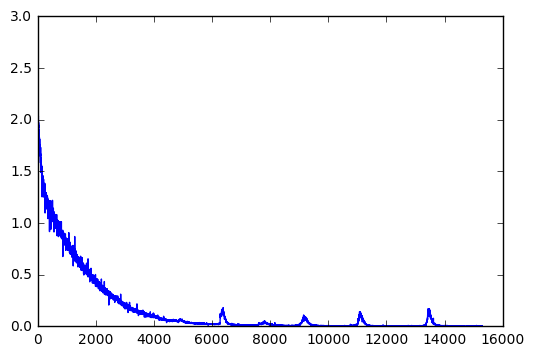

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(error)

In [34]:
note = 'n_train: %d, n_mid: %d\n'%(n_train, n_mid) + \
       '入力 X → Encoder → 変換素子 → dropout → Decoder(Attention) → 出力'
data = {'model' : model,
        'epochs': n_epoch,
        'errors': error,
        'note'  : note}
with open('model/seq2seq-full-atteention-%depochs.mdl'%n_epoch, 'wb') as f:
    pickle.dump(data, f)

In [15]:
import pickle
with open('model/model-i/seq2seq-Full-atteentionII-250epochs.mdl', 'rb') as f:
    modeldata = pickle.load(f)

md = modeldata['model']

title =['この素晴らしい世界に祝福を！２',
        'あいまいみー ～Surgical Friends～',
        '小林さんちのメイドラゴン',
        'Fate／Grand Order ‐First Order‐',
        '幼女戦記',
        '亜人ちゃんは語りたい',
        'ガウリールドロップアウト',
        'けものフレンズ',
        '学戦都市アスタリスク'
       ]
D = t_wd2id(title)
for i in range(len(D)):
    D[i].append(-1)
D = np.array([np.array(d, dtype=np.int32) for d in D])

P = c_wd2id.translate(md.predict(D, max_iter=50))
for i, p in enumerate(P):
    print('『'+title[i]+'』:\n    ', p)

『この素晴らしい世界に祝福を！２』:
     バ ト ル ア ク シ ョ ン も ！ ？ 怒 涛 の 第 四 巻 ！ <eos> 
『あいまいみー ～Surgical Friends～』:
     中 二 病 を 脱 却 ! ? 「 最 」 の 世 界 で 、 少 年 は 少 年 を 取 り 戻 す の は ― ― ! ? <eos> 
『小林さんちのメイドラゴン』:
     天 才 ニ ー ト × 頭 脳 バ ト ル × 異 世 界 フ ァ ン タ ジ ー 、 第 二 弾 ！ <eos> 
『Fate／Grand Order ‐First Order‐』:
     最 強 妄 想 ヒ ロ イ ン 、 つ い に 発 動 す ! ! <eos> 
『幼女戦記』:
     二 人 の 女 の 子 と 運 命 を 、 お し て か 、 そ れ と も ― ― ？ <eos> 
『亜人ちゃんは語りたい』:
     待 望 の 最 新 作 、 登 場 ！ <eos> 
『ガウリールドロップアウト』:
     り 上 等 と 出 会 う ！ そ し て リ オ ン が 挑 む ！ <eos> 
『けものフレンズ』:
     学 校 復 活 で 贈 る 、 大 人 気 学 園 戦 国 フ ァ ン タ ジ ー 、 第 七 話 開 幕 ！ <eos> 
『学戦都市アスタリスク』:
     が わ け た し は ― ― ホ ー ム で 、 屈 指 し た 西 也 の 次 の ス テ ィ ー ジ だ ！ <eos> 
